In [1]:
# Author: Kin Man Lam
# StudentID: 15823898
# MATH7017 Probabilistic Graphical Models

import os
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


# Hyperparameters
input_size = 784  # 28x28
latent_dim = 64
hidden_size = 512
num_classes = 10  # 10 classes for the 10 digits
num_samples = 10  # 10 samples generated for each class
epochs = 50
batch_size = 100
learning_rate = 0.001

c:\Users\keyma\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Use GPU to do computations if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Create directory for storing MNIST data
os.makedirs('mnist_data', exist_ok=True)

## CVAE Model

In [4]:
# Define the CVAE model
class CVAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_dim, num_classes):
        super(CVAE, self).__init__()

        self.encoder_input_dim = input_size + num_classes # Input dimension is sum of input size and number of classes
        self.decoder_input_dim = latent_dim + num_classes # Input dimension is sum of latent dimension and number of classes

        # Encoder
        self.fc1 = nn.Linear(self.encoder_input_dim, hidden_size) # The first hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # The second hidden layer
        self.fc_mu = nn.Linear(hidden_size, latent_dim)
        self.fc_logvar = nn.Linear(hidden_size, latent_dim)

        # Decoder
        self.fc4 = nn.Linear(self.decoder_input_dim, hidden_size) # The first hidden layer
        self.fc5 = nn.Linear(hidden_size, hidden_size) # The second hidden layer
        self.fc6 = nn.Linear(hidden_size, input_size)

    # Function for the encoder
    def encode(self, x, labels): # labels is the condition which is concatenated with x
        x = torch.cat((x, labels), dim=1) # Concatenate input with condition
        h = F.relu(self.fc1(x)) # Pass through the first hidden layer
        h = F.relu(self.fc2(h)) # Pass through the second hidden layer
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    # Function for reparameterisation trick
    def reparameterise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(device)
        return mu + eps * std
    
    # Function for the decoder
    def decode(self, z, labels): # labels is concatenated with z
        z = torch.cat((z, labels), dim=1)
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))
    
    # Forward propagation 
    def forward(self, x, labels):
        mu, logvar = self.encode(x.view(-1, input_size), labels)
        z = self.reparameterise(mu, logvar)
        return self.decode(z, labels), mu, logvar

In [5]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum') # Binary cross entropy loss

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # Kullback-Leibler divergence loss
    return BCE + KLD # Return total loss

In [6]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./mnist_data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Create an instance of the model and optimiser
model = CVAE(input_size, hidden_size, latent_dim, num_classes).to(device)
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

Epoch [1/50], Average Loss: 16406.63058268229
Epoch [2/50], Average Loss: 12122.882615559896
Epoch [3/50], Average Loss: 11255.67636393229
Epoch [4/50], Average Loss: 10805.582000325521
Epoch [5/50], Average Loss: 10524.392278645833
Epoch [6/50], Average Loss: 10317.079222005208
Epoch [7/50], Average Loss: 10176.256284179688
Epoch [8/50], Average Loss: 10056.711967773437
Epoch [9/50], Average Loss: 9949.873728841147
Epoch [10/50], Average Loss: 9867.597438151042
Epoch [11/50], Average Loss: 9805.005836588542
Epoch [12/50], Average Loss: 9737.836150716146
Epoch [13/50], Average Loss: 9696.753435872395
Epoch [14/50], Average Loss: 9646.346311848958
Epoch [15/50], Average Loss: 9611.700164388021
Epoch [16/50], Average Loss: 9583.649404296875
Epoch [17/50], Average Loss: 9555.288883463541
Epoch [18/50], Average Loss: 9520.027669270834
Epoch [19/50], Average Loss: 9498.2122265625
Epoch [20/50], Average Loss: 9485.267861328124
Epoch [21/50], Average Loss: 9456.745817057292
Epoch [22/50], Ave

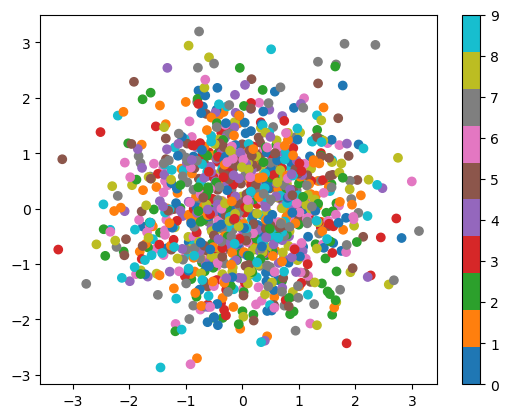

In [8]:
# Function to train the CVAE model
def train_cvae_model(model, train_loader):
    # Dataframe to store losses
    loss_df = pd.DataFrame(columns=['epoch', 'avg_loss'])
    
    # Loop through each epoch
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0

        # Loop through each batch
        for i, (x, labels) in enumerate(train_loader):
            x = x.to(device)
            x = x.view(x.shape[0], -1)  # Flatten the input
            labels = F.one_hot(labels, num_classes).float().to(device) # One-hot encode labels

            recon_images, mu, logvar = model(x, labels) # Forward pass
            loss = loss_function(recon_images, x, mu, logvar) # Calculate loss

            optimiser.zero_grad() # Zero gradients
            loss.backward() # Backpropagation
            optimiser.step() # Update weights

            train_loss += loss.item() # Add the loss
        
        # Calculate average loss for this epoch
        avg_loss = train_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss}')

        # Add epoch and avg_loss to loss_df
        temp_df = pd.DataFrame({'epoch': [epoch + 1], 'avg_loss': [avg_loss]})
        loss_df = pd.concat([loss_df, temp_df], ignore_index=True)

        # Visualise the latent space at the last epoch
        if epoch == epochs - 1:
            model.eval()  # set model to evaluation mode
            with torch.no_grad():
                # Loop through the first few batches
                for i, (x, labels) in enumerate(train_loader):
                    x = x.to(device).view(-1, input_size)
                    labels = F.one_hot(labels, num_classes).to(device)
            
                    mu, logvar = model.encode(x, labels) # Get the mu and logvar of the latent space
                    z = model.reparameterise(mu, logvar) # Apply reparameterisation

                    z = z.cpu().numpy()  # Convert to numpy array for plotting
                    plt.scatter(z[:, 0], z[:, 1], c=labels.argmax(dim=1).cpu(), cmap='tab10') # Plot the latent variables and colour code them with the labels
                    if i >= 10:  # Only plot the first 10 batches
                        break

                plt.colorbar()
                plt.savefig("latent_space.png") # Save the plot
                plt.show()
                
            model.train() # Set model back to training mode
    
    loss_df.to_csv('avg_loss_per_epoch.csv', index=False) # Save loss_df to csv

    torch.save(model.state_dict(), 'trained_cvae_model.pt') # Save the trained model parameters

    return model # Return trained model

# Train the model
trained_cvae_model = train_cvae_model(model, train_loader)

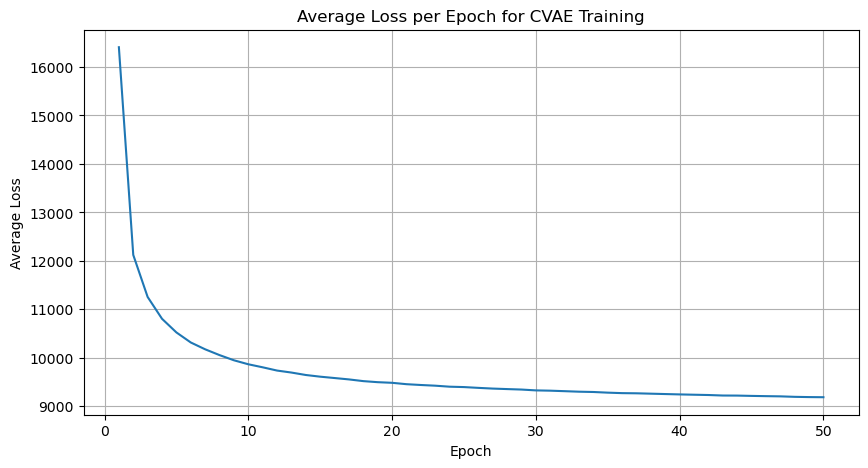

In [9]:
# Load the average loss per epoch from training and and plot it
loss_df = pd.read_csv('avg_loss_per_epoch.csv')

# Create a plot for the average loss per epoch
plt.figure(figsize=(12, 6))
plt.plot(loss_df['epoch'], loss_df['avg_loss'])
plt.title("Average Loss per Epoch for CVAE Training")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.savefig("avg_loss_per_epoch.png")
plt.show()

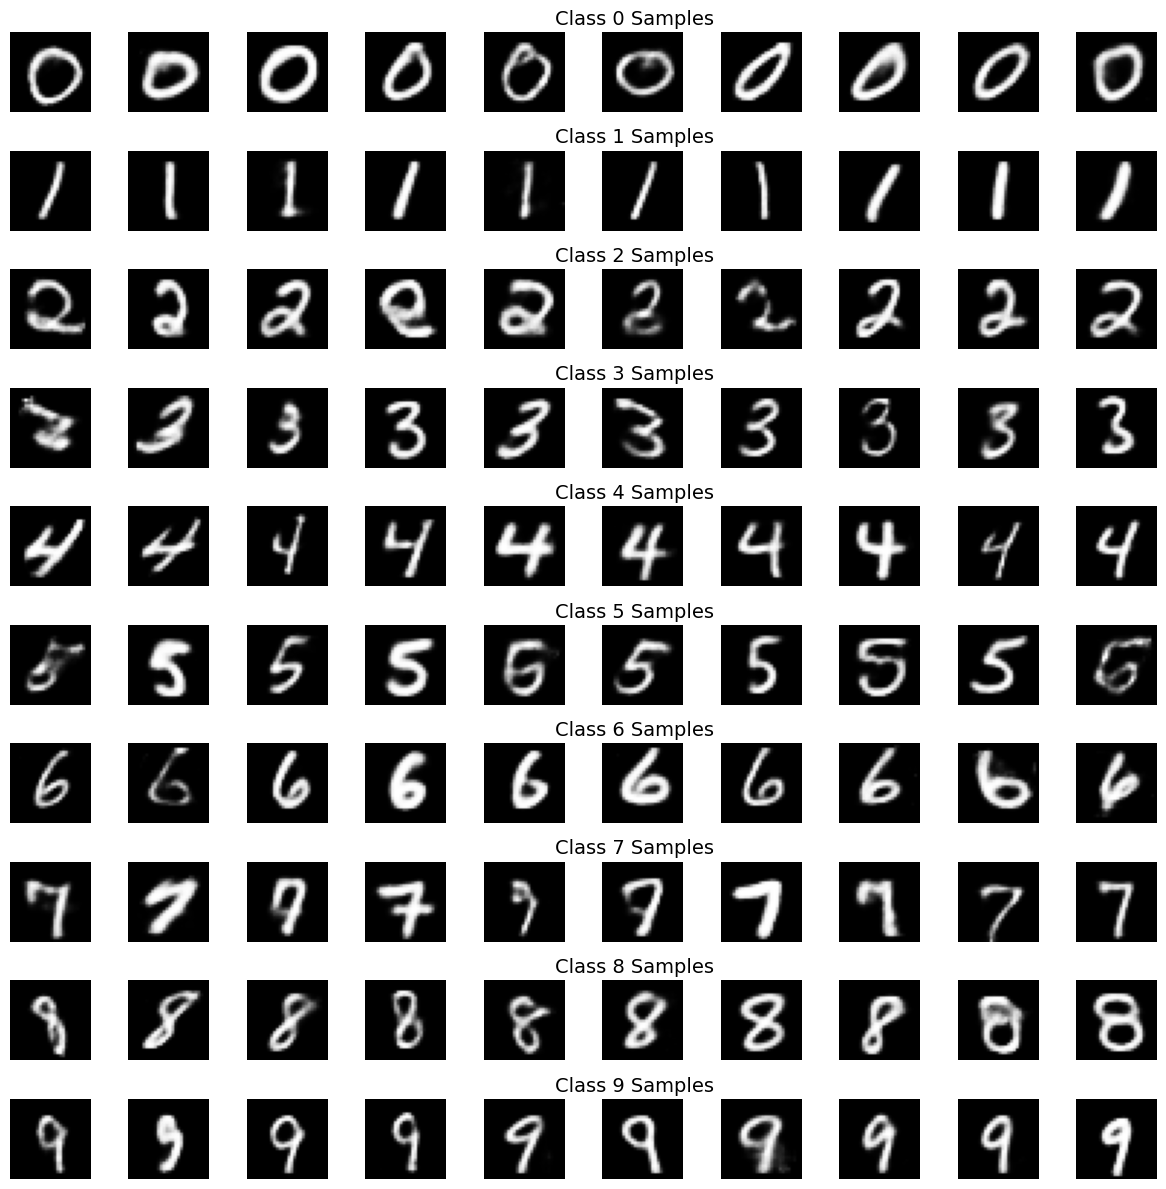

In [10]:
# Function to test the CVAE model by generating and displaying samples
def test_cvae_model(model, num_samples, num_classes, latent_dim, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Prepare the grid for images
        fig, axs = plt.subplots(num_classes, num_samples, figsize=(12, 12))
        
        for i in range(num_classes):
            # Create one-hot encoded labels for each class
            fixed_labels = F.one_hot(torch.tensor([i]*num_samples), num_classes).float().to(device)
            fixed_z = torch.randn(num_samples, latent_dim).to(device)

            # Generate and display samples for each digit
            samples = model.decode(fixed_z, fixed_labels).cpu()
            for j in range(num_samples):
                axs[i, j].imshow(samples[j].view(28, 28).numpy(), cmap='gray')
                axs[i, j].axis('off')

            # Set titles with bigger font and slightly moved to the left
            axs[i, num_samples // 2].set_title(f"Class {i} Samples", fontsize=14, x=0.4)

        plt.tight_layout()
        plt.savefig("CVAE_samples.png")
        plt.show()

# Test the model
test_cvae_model(trained_cvae_model, num_samples, num_classes, latent_dim, device)

## CVAE Classifer

In [11]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) # The hidden layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output = F.relu(self.fc1(x))
        output = self.fc2(output)
        return output

In [12]:
# Function to train classifier using the CVAE
def train_cvae_classifier(classifier, cvae_model, train_loader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(classifier.parameters(), learning_rate)

    cvae_model.eval()  # No need to train the CVAE here
    for epoch in range(epochs):
        train_loss = 0  # Initialise train loss at the start of each epoch
        for _, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(images.shape[0], -1)  # Flatten the input

            # Get the latent representation from the CVAE model
            _, mu, _ = cvae_model(images, F.one_hot(labels, num_classes).float().to(device))

            # Forward pass
            outputs = classifier(mu)
            loss = criterion(outputs, labels)

            train_loss += loss.item()

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        avg_loss = train_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss}')

    return classifier # Return the trained classifier

# Initialise the classifier and train it
cvae_classifier = Classifier(latent_dim, hidden_size, num_classes).to(device)
trained_cvae_classifier = train_cvae_classifier(cvae_classifier, trained_cvae_model, train_loader, epochs)

Epoch [1/50], Average Loss: 1.2887322814762592
Epoch [2/50], Average Loss: 0.3339259568850199
Epoch [3/50], Average Loss: 0.1780332281937202
Epoch [4/50], Average Loss: 0.1213519461452961
Epoch [5/50], Average Loss: 0.09115511155376832
Epoch [6/50], Average Loss: 0.07259702789286772
Epoch [7/50], Average Loss: 0.05909098369690279
Epoch [8/50], Average Loss: 0.04977137554436922
Epoch [9/50], Average Loss: 0.04254350387491286
Epoch [10/50], Average Loss: 0.036799544535266855
Epoch [11/50], Average Loss: 0.03150100220072394
Epoch [12/50], Average Loss: 0.027293790606781842
Epoch [13/50], Average Loss: 0.023857973848159113
Epoch [14/50], Average Loss: 0.021062065908530107
Epoch [15/50], Average Loss: 0.01868496185207429
Epoch [16/50], Average Loss: 0.01692207484312045
Epoch [17/50], Average Loss: 0.014210135484657561
Epoch [18/50], Average Loss: 0.013355173996339242
Epoch [19/50], Average Loss: 0.011522146872399996
Epoch [20/50], Average Loss: 0.010250216706384284
Epoch [21/50], Average Lo

In [25]:
# Function to test the classifier on CVAE
def test_cvae_classifier(classifier, cvae_model, test_loader):
    correct = 0
    total = 0
    classifier.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(images.shape[0], -1)

            _, mu, _ = cvae_model(images, F.one_hot(labels, num_classes).float().to(device))
            outputs = classifier(mu)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the classifier on the generated images: {accuracy}%')

# Test the trained classifier
test_cvae_classifier(trained_cvae_classifier, trained_cvae_model, test_loader)

Accuracy of the classifier on the generated images: 99.29%


## CGAN Model

In [14]:
# Define the generator model for the CGAN
class Generator(nn.Module):
    def __init__(self, latent_dim, img_dim, num_classes):
        super(Generator, self).__init__()

        # Define a sequential model
        self.gen = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_size), # Input is concatenated noise and label
            nn.BatchNorm1d(hidden_size), # Batch normalisation to improve training
            nn.LeakyReLU(0.2), # LeakyReLU prevents dying ReLU problem
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, img_dim), # Output is the generated image
            nn.Tanh() # Tanh is commonly used for the generator's output layer
        )

    def forward(self, noise, labels): # labels is the condition which is concatenated with x
        z = torch.cat((noise, labels), dim=1) # Concatenating noise (latent space vector) and labels (one-hot encoded)
        return self.gen(z) # Pass the concatenated vector through the network

# Define the discriminator model for the CGAN
class Discriminator(nn.Module):
    def __init__(self, img_dim, num_classes):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim + num_classes, hidden_size), # Input is concatenated real/generated image and label
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3), # Dropout for regularisation
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1), # Output is the probability that the input image is real
            nn.Sigmoid() # Sigmoid function for a binary classification probability
        )

    def forward(self, x, labels):
        x = torch.cat((x, labels), dim=1)
        return self.disc(x)

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(), # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalise the image to have values between -1 and 1
])

train_dataset_2 = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
train_loader_2 = DataLoader(dataset=train_dataset_2, batch_size=batch_size, shuffle=True)

test_dataset_2 = datasets.MNIST(root='./mnist_data', train=False, transform=transform)
test_loader_2 = torch.utils.data.DataLoader(dataset=test_dataset_2, batch_size=batch_size, shuffle=False)

In [16]:
# Create instances of the generator and discriminator models
generator = Generator(latent_dim, input_size, num_classes).to(device)
discriminator = Discriminator(input_size, num_classes).to(device)

# Define the optimisers for the generator and discriminator
opt_gen = torch.optim.Adam(generator.parameters(), learning_rate)
opt_disc = torch.optim.Adam(discriminator.parameters(), learning_rate)

# Define the loss function as Binary Cross Entropy Loss
criterion = nn.BCELoss() 

In [17]:
# Function to train the CGAN model
def train_cgan_model(epochs, train_loader_2, generator, discriminator, opt_gen, opt_disc, criterion, device, \
              latent_dim, num_classes, input_size):
    
    generator.train() # Set generator model to training mode
    discriminator.train() # Set discriminator model to training mode
    lossD_values = [] # List to save discriminator losses
    lossG_values = [] # List to save generator losses

    for epoch in range(epochs):
        for batch_idx, (real, labels) in enumerate(train_loader_2): # Loop over all batches
            real = real.view(-1, input_size).to(device) # Flatten and move real images to device
            labels = F.one_hot(labels, num_classes).float().to(device) # One-hot encode and move labels to device
            batch_size = real.shape[0] # Get batch size
            noise = torch.randn(batch_size, latent_dim).to(device) # Generate noise vector

            fake = generator(noise, labels) # Generate fake images

            # Calculate discriminator loss for real and fake images
            disc_real = discriminator(real, labels).view(-1)
            lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            disc_fake = discriminator(fake.detach(), labels).view(-1)
            lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            lossD = (lossD_real + lossD_fake) / 2 # Average real and fake loss
            
            # Backpropagate on the discriminator
            discriminator.zero_grad()
            lossD.backward()
            opt_disc.step()

            # Calculate generator loss
            output = discriminator(fake, labels).view(-1)
            lossG = criterion(output, torch.ones_like(output))

            # Backpropagate on the generator
            generator.zero_grad()
            lossG.backward()
            opt_gen.step()

            # Save losses for this batch
            lossD_values.append(lossD.item())
            lossG_values.append(lossG.item())

            # Print losses for the first batch in each epoch
            if batch_idx == 0:
                print(f"Epoch [{epoch + 1}/{epochs}] Batch {batch_idx}/{len(train_loader_2)} \
                       Loss D: {lossD:.4f}, loss G: {lossG:.4f}")
                
    # Save losses to a csv file
    loss_df = pd.DataFrame({
        'lossD': lossD_values,
        'lossG': lossG_values,
    })
    loss_df.to_csv('loss_values.csv', index=False)

    # Save model states
    torch.save(generator.state_dict(), 'generator_model.pt')
    torch.save(discriminator.state_dict(), 'discriminator_model.pt')

    return generator, discriminator

# Train the model
generator, discriminator = train_cgan_model(epochs, train_loader_2, generator, discriminator, opt_gen, opt_disc, \
                                     criterion, device, latent_dim, num_classes, input_size)

Epoch [1/50] Batch 0/600                        Loss D: 0.7466, loss G: 0.7235
Epoch [2/50] Batch 0/600                        Loss D: 0.0037, loss G: 20.0897
Epoch [3/50] Batch 0/600                        Loss D: 0.0303, loss G: 14.7826
Epoch [4/50] Batch 0/600                        Loss D: 0.0447, loss G: 8.6752
Epoch [5/50] Batch 0/600                        Loss D: 0.0069, loss G: 19.4310
Epoch [6/50] Batch 0/600                        Loss D: 0.0207, loss G: 7.4021
Epoch [7/50] Batch 0/600                        Loss D: 0.0786, loss G: 8.7709
Epoch [8/50] Batch 0/600                        Loss D: 0.2314, loss G: 4.3870
Epoch [9/50] Batch 0/600                        Loss D: 0.2071, loss G: 5.8034
Epoch [10/50] Batch 0/600                        Loss D: 0.3490, loss G: 2.5406
Epoch [11/50] Batch 0/600                        Loss D: 0.4165, loss G: 2.8552
Epoch [12/50] Batch 0/600                        Loss D: 0.6733, loss G: 3.4963
Epoch [13/50] Batch 0/600                     

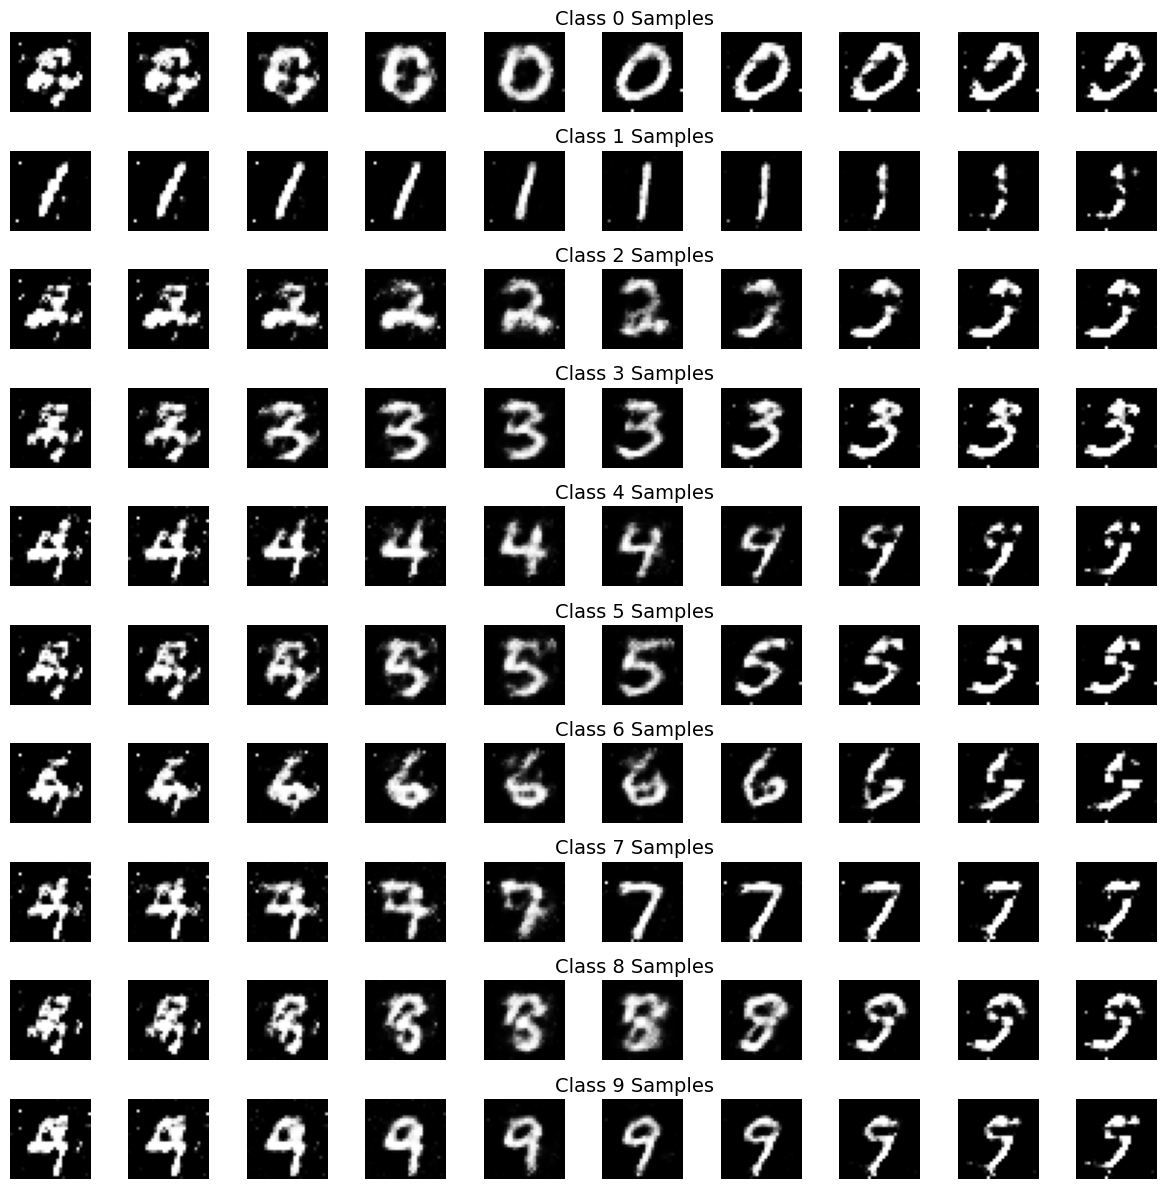

In [18]:
# Function to visualise the Latent Space of the CGAN
def visualise_cgan_latent_space(generator, num_samples, num_classes, latent_dim, device):
    generator.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Prepare the grid for images
        fig, axs = plt.subplots(num_classes, num_samples, figsize=(12, 12))
        
        for i in range(num_classes): # Loop over each class
            # Create one-hot encoded labels for each class
            fixed_labels = F.one_hot(torch.tensor([i]*num_samples), num_classes).float().to(device)
            # Create a range of noise vectors instead of random ones
            fixed_z = torch.linspace(-2, 2, num_samples).unsqueeze(1).repeat(1, latent_dim).to(device)

            # Generate samples using the generator
            samples = generator(fixed_z, fixed_labels).cpu()

            for j in range(num_samples): # Loop over each sample
                # Display generated images
                axs[i, j].imshow(samples[j].view(28, 28).numpy(), cmap='gray')
                axs[i, j].axis('off') # Remove axes

            # Set titles for each row
            axs[i, num_samples // 2].set_title(f"Class {i} Samples", fontsize=14, x=0.4)

        plt.tight_layout()
        plt.savefig("CGAN_latent_space.png")
        plt.show()

# Call the function to visualise the latent space of the trained CGAN model
visualise_cgan_latent_space(generator, num_samples, num_classes, latent_dim, device)

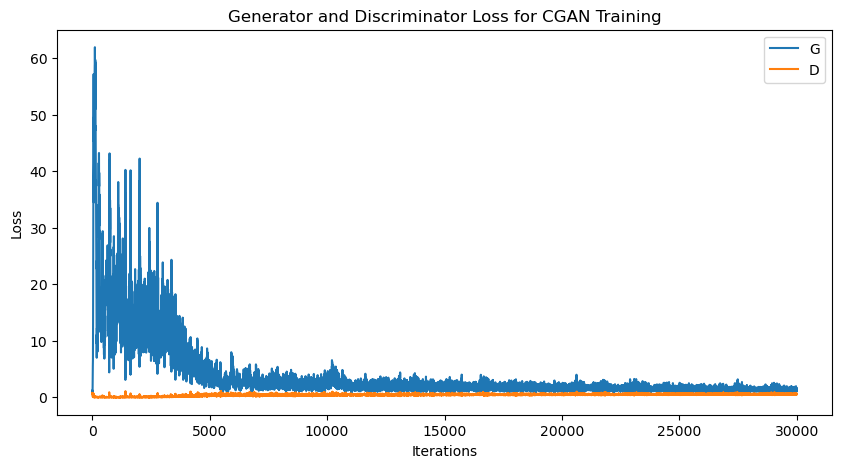

In [19]:
# Load the loss values from file
loss_df_2 = pd.read_csv('loss_values.csv')

# Create a plot for the loss values
plt.figure(figsize=(12, 6))
plt.title("Generator and Discriminator Loss for CGAN Training")
plt.plot(loss_df_2['lossG'],label="G")
plt.plot(loss_df_2['lossD'],label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("lossD & lossG.png")
plt.show()

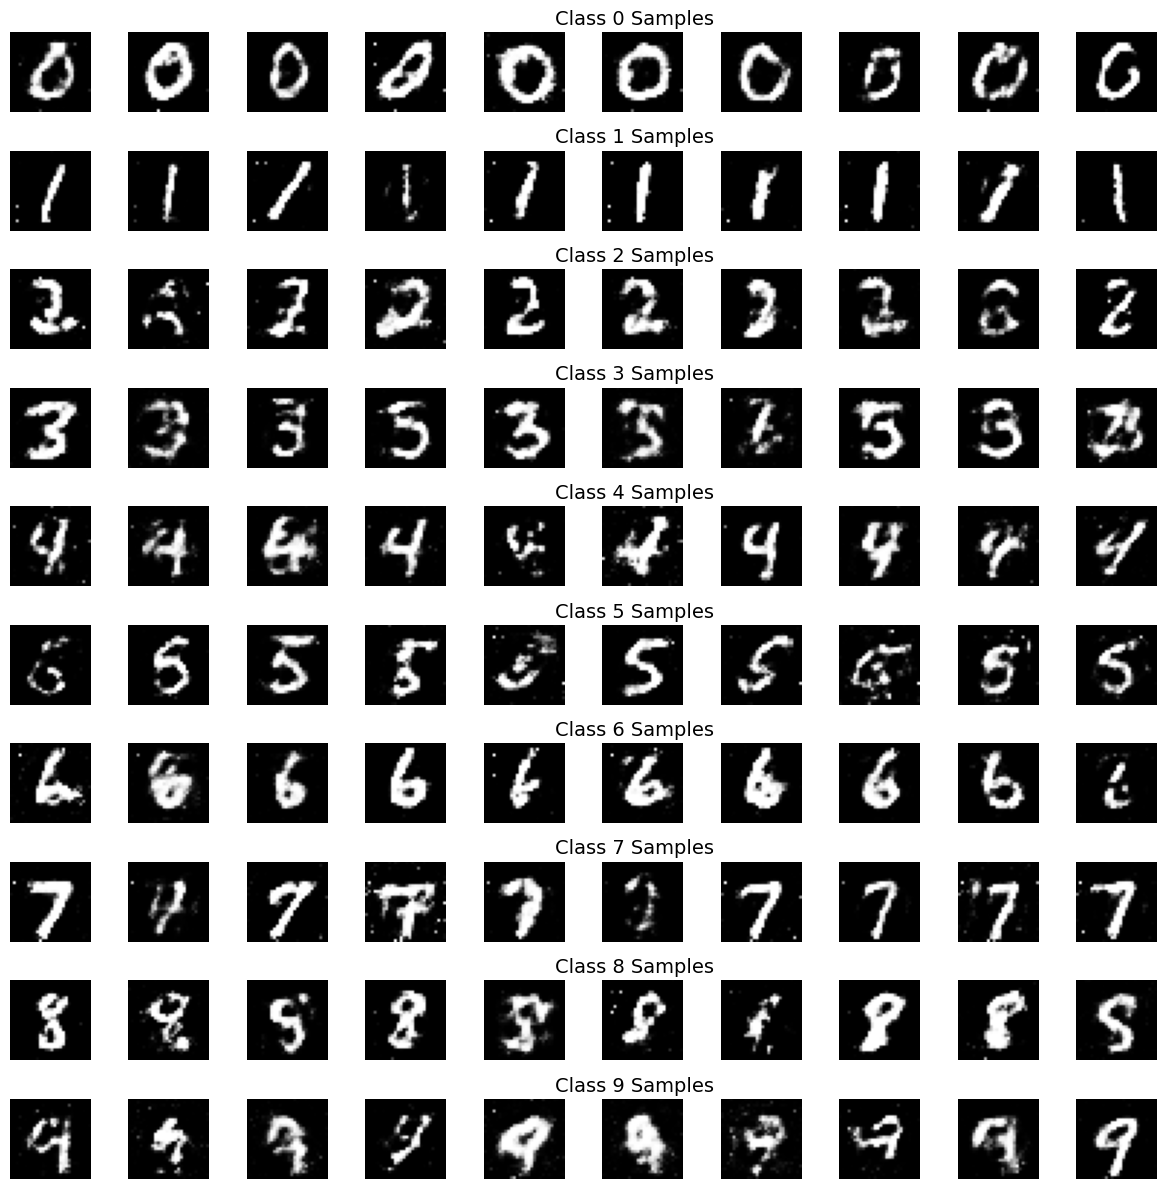

In [76]:
# Function to test the CGAN Model by generating and displaying samples
def test_cgan_model(generator, num_samples, num_classes, latent_dim, device):
    generator.eval()  # Set the generator to evaluation mode

    # Generate and display samples for each class
    with torch.no_grad():
        fig, axs = plt.subplots(num_classes, num_samples, figsize=(12, 12))
        
        # Loop for each class
        for i in range(num_classes):
            # Generate samples for current class
            labels = F.one_hot(torch.tensor([i]*num_samples), num_classes).float().to(device)
            noise = torch.randn(num_samples, latent_dim).to(device)
            samples = generator(noise, labels).cpu().reshape(-1, 28, 28)

            # Display generated images
            for j in range(num_samples):
                axs[i, j].imshow(samples[j].numpy(), cmap='gray')
                axs[i, j].axis('off')

            # Set the title for current class samples
            axs[i, num_samples // 2].set_title(f"Class {i} Samples", fontsize=14, x=0.4)

        plt.tight_layout()
        plt.savefig("CGAN_samples.png")
        plt.show()

# Test the model
test_cgan_model(generator, 10, num_classes, latent_dim, device) 

## CGAN Classifer
#### Use the classifier function for the CVAE again

In [21]:
# Function to train classifier using the CGAN
def train_cgan_classifier(classifier, generator, train_loader_2, num_epochs):
    # Initialise loss function and optimiser
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

    # Train the classifier
    generator.eval()  # # No need to train the generator here
    for epoch in range(num_epochs):
        train_loss = 0  # reset the training loss for each epoch
        for _, (images, labels) in enumerate(train_loader_2):
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(images.shape[0], -1)

            # Get the generated images from the generator model
            noise = torch.randn(batch_size, latent_dim).to(device)
            gen_labels = F.one_hot(torch.randint(0, num_classes, (batch_size,)), num_classes).float().to(device)
            gen_images = generator(noise, gen_labels).detach()

            # Forward pass
            outputs = classifier(gen_images)
            loss = criterion(outputs, gen_labels.argmax(dim=1))

            train_loss += loss.item()

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        avg_loss = train_loss / len(train_loader_2)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

    return classifier

# Initialise the classifier and train it
cgan_classifier = Classifier(input_size, hidden_size, num_classes).to(device)
trained_cgan_classifier = train_cgan_classifier(cgan_classifier, generator, train_loader_2, epochs)

Epoch [1/50], Average Loss: 0.1345
Epoch [2/50], Average Loss: 0.0570
Epoch [3/50], Average Loss: 0.0520
Epoch [4/50], Average Loss: 0.0466
Epoch [5/50], Average Loss: 0.0464
Epoch [6/50], Average Loss: 0.0423
Epoch [7/50], Average Loss: 0.0399
Epoch [8/50], Average Loss: 0.0350
Epoch [9/50], Average Loss: 0.0382
Epoch [10/50], Average Loss: 0.0374
Epoch [11/50], Average Loss: 0.0339
Epoch [12/50], Average Loss: 0.0340
Epoch [13/50], Average Loss: 0.0304
Epoch [14/50], Average Loss: 0.0334
Epoch [15/50], Average Loss: 0.0322
Epoch [16/50], Average Loss: 0.0307
Epoch [17/50], Average Loss: 0.0299
Epoch [18/50], Average Loss: 0.0324
Epoch [19/50], Average Loss: 0.0292
Epoch [20/50], Average Loss: 0.0283
Epoch [21/50], Average Loss: 0.0293
Epoch [22/50], Average Loss: 0.0262
Epoch [23/50], Average Loss: 0.0267
Epoch [24/50], Average Loss: 0.0282
Epoch [25/50], Average Loss: 0.0261
Epoch [26/50], Average Loss: 0.0268
Epoch [27/50], Average Loss: 0.0241
Epoch [28/50], Average Loss: 0.0246
E

In [28]:
# Function to test the classifier on CGAN
def test_cgan_classifier(classifier, generator, test_loader_2, num_samples):
    correct = 0
    total = 0
    classifier.eval()
    generator.eval()

    # Evaluate classifier accuracy on generated images
    with torch.no_grad():
        for images, labels in test_loader_2:
            labels = labels.to(device)
            for i in range(images.size(0)):  # Generate images one at a time for each label in the batch
                gen_label = F.one_hot(labels[i:i+1], num_classes).float().to(device)
                noise = torch.randn(1, latent_dim).to(device)  # Only generate one image at a time
                gen_image = generator(noise, gen_label).detach()

                output = classifier(gen_image)
                _, predicted = torch.max(output.data, 1)
                total += 1
                correct += (predicted == gen_label.argmax(dim=1)).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the classifier on the generated images: {accuracy}%')

# Test the trained classifier
test_cgan_classifier(trained_cgan_classifier, generator, test_loader_2, num_samples)

Accuracy of the classifier on the generated images: 99.27%
